In [ ]:
from src.utils import yaml_config_hook
from src.loaders import *
from src.models import ResNet1D
from src.trainers import *

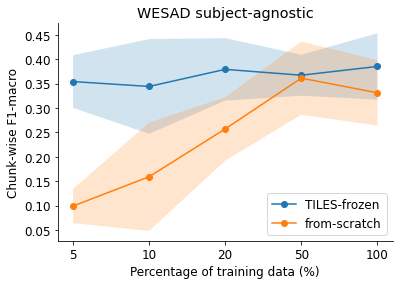

In [89]:
dataset = "WESAD"
file_list_1 = [f"{dataset}_frozen_005", f"{dataset}_frozen_010", f"{dataset}_frozen_020", f"{dataset}_frozen_050", f"{dataset}_frozen"]
file_list_2 = [f"{dataset}_scratch_005", f"{dataset}_scratch_010", f"{dataset}_scratch_020", f"{dataset}_scratch_050", f"{dataset}_scratch"]

plot_results(file_list_1, file_list_2, metric='Chunk-wise F1-macro')

In [ ]:
import os, pickle, neurokit2 as nk
import numpy as np, pandas as pd
from scipy.signal import resample_poly
from sklearn.preprocessing import StandardScaler
from torch.utils import data
from tqdm import tqdm

os.makedirs("data/mirise", exist_ok=True)


class MIRISE(data.Dataset):
    def __init__(self, root, sr):
        super().__init__()
        self.root = root
        self.sr = sr
        self.win = sr * 10
        self.pps = list(range(1, 20))
        self.pps.remove(7)
        self.pps.remove(8)
        self.pps = [f"00{i}" if i < 10 else f"0{i}" for i in self.pps]

        ecg_all, lab_all, names = [], [], []
        print("Loading participant data...")
        for p in tqdm(self.pps):

            if os.path.exists(f"data/mirise/{p}_ecg.pkl"):
                with open(f"data/mirise/{p}_ecg.pkl", "rb") as f:
                    ecg = pickle.load(f)
                with open(f"data/mirise/{p}_lab.pkl", "rb") as f:
                    lab = pickle.load(f)
            else:
                ecg, lab = {}, {}
                for condition in os.listdir(f"{self.root}/{p}"):
                    data = pd.read_csv(
                        f"{self.root}/{p}/{condition}/PolymatePhysiologicalSignals.csv"
                    )

                    this_ecg = self.preprocess(data["ecg"])
                    this_lab = (
                        np.zeros(len(this_ecg))
                        if condition == "sunny"
                        else np.ones(len(this_ecg))
                    )
                    ecg[condition] = this_ecg
                    lab[condition] = this_lab

                with open(f"data/mirise/{p}_ecg.pkl", "wb") as f:
                    pickle.dump(ecg, f, protocol=pickle.HIGHEST_PROTOCOL)
                with open(f"data/mirise/{p}_lab.pkl", "wb") as f:
                    pickle.dump(lab, f, protocol=pickle.HIGHEST_PROTOCOL)

            unraveled = [v for _, v in ecg.items()]
            ecg_all.extend(unraveled)
            lab_all.extend([v for _, v in lab.items()])
            names += [p] * len(np.vstack(unraveled))

        self.samples = np.vstack(ecg_all)
        self.samples = StandardScaler().fit_transform(self.samples)
        self.labels = np.concatenate(lab_all)
        self.names = names

        print(f"Loaded {len(self.labels)} ECG samples in total.")

    def preprocess(self, ecg):
        # downsample to 100Hz
        new_len = int((len(ecg) / 500) * self.sr)
        proc = resample_poly(ecg, self.sr, 500)[:new_len]
        # BP filtering
        proc = nk.ecg_clean(proc, sampling_rate=self.sr)
        # segment into 10 sec windows
        proc = [proc[i : i + self.win] for i in range(0, len(proc), self.win)]
        # discard first and last window
        return np.stack(proc[1:-1])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ecg = self.samples[idx]
        lab = self.labels[idx]
        nam = self.names[idx]
        return ecg, lab, nam


if __name__ == "__main__":
    root = "/home/kavra/Datasets/toyota_simulator/"
    dataset = MIRISE(root, sr=100)
    print(dataset[0][0].shape, dataset[0][1], dataset[0][2])


In [2]:
import numpy as np, pickle 
with open(f"data/mirise/001_ecg.pkl", "rb") as f:
    ecg = pickle.load(f)
with open(f"data/mirise/001_lab.pkl", "rb") as f:
    lab = pickle.load(f)

In [7]:
ecg

{'sunny': array([[ -15.62840471,    2.33794347,   28.11982108, ...,  854.13204224,
          169.5694762 ,  -43.61683034],
        [ -29.0193695 ,  -72.34065288, -131.17853352, ...,  330.30811087,
          222.60156904,  117.95764117],
        [  37.03175604,  -19.46590361,  -58.57105082, ..., -131.94747067,
         -142.76221394, -157.71953741],
        ...,
        [ -96.57347513,  -38.48117089,  -27.53533835, ..., -137.4043232 ,
         -129.93518065, -116.48855121],
        [-104.13283699,  -89.48990734,  -70.54756589, ...,  -29.98737665,
           16.77447105,   41.3750229 ],
        [  37.32743741,  -20.1647087 ,  -96.21232061, ...,   92.41600582,
          156.31508883,  191.73736169]]),
 'rainy': array([[  19.49591234,  -59.21038193, -138.52766432, ...,  115.19908894,
           32.72220563,  -23.77485717],
        [ -60.49748357,  -81.69193436,  -92.18746468, ...,  -97.08685679,
          -86.13246739,  -79.90409617],
        [ -79.77043236,  -78.43787331,  -69.97920089, .

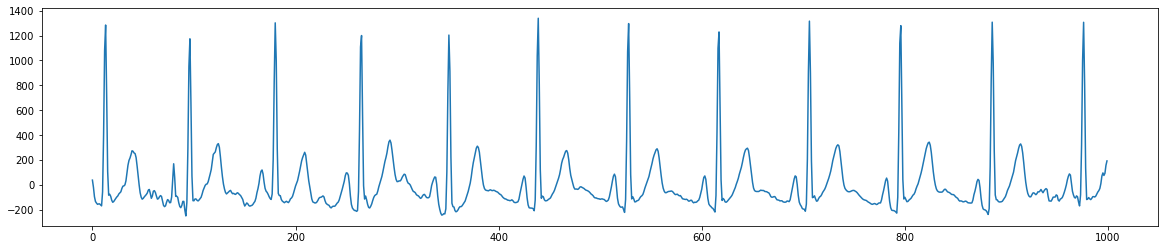

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
plt.plot(ecg["sunny"][-1])

In [26]:
ecg["rainy"].max(axis=0).mean()

1570.934696914303

In [43]:
a = np.load("data/wesad/S5_ecg.npy")

In [44]:
plt.figure(figsize=(20, 4))
a.max(axis=0).mean()

1.196743267375922

<Figure size 1440x288 with 0 Axes>

In [45]:
a.shape

(217, 1000)

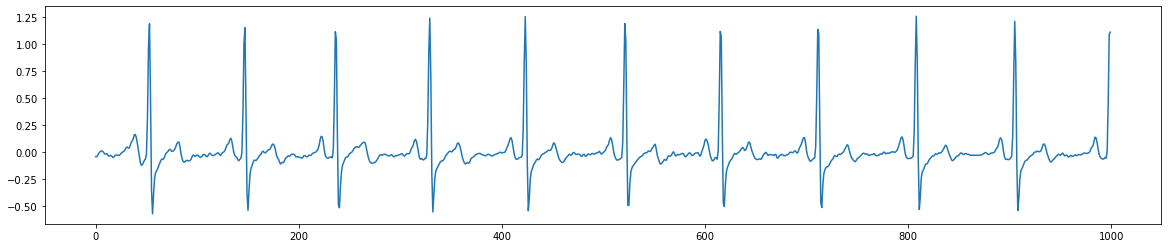

In [46]:
plt.figure(figsize=(20, 4))
plt.plot(a[2])